In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2026-02-08 11:12:36.529958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770549156.999671      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770549157.118571      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770549158.024570      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770549158.024616      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770549158.024619      55 computation_placer.cc:177] computation placer alr

In [2]:
# Exact path for this dataset on Kaggle
BASE_DIR = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256"

TRAIN_DIR = os.path.join(BASE_DIR, "Training")
VAL_DIR   = os.path.join(BASE_DIR, "Validation")
TEST_DIR  = os.path.join(BASE_DIR, "Testing")

IMG_SIZE = 224          # MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 60             # max — early stopping will halt earlier
SEED = 42

print("Training classes:", os.listdir(TRAIN_DIR))
print("Validation classes:", os.listdir(VAL_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Training classes: ['Late_Blight', 'Early_Blight', 'Healthy']
Validation classes: ['Late_Blight', 'Early_Blight', 'Healthy']
Testing classes: ['Late_Blight', 'Early_Blight', 'Healthy']


In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.65, 1.35],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)
print("Indices:", train_generator.class_indices)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Class names: ['Early_Blight', 'Healthy', 'Late_Blight']
Indices: {'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}


In [4]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False   # freeze initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(320, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Dense(160, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')]
)

model.summary()

I0000 00:00:1770549180.699093      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770549180.705171      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │       409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,721,667 (10.38 MB)

 Trainable params: 462,723 (1.77 MB)

 Non-trainable params: 2,258,944 (8.62 MB)

In [5]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0005
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenetv2_pld.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [6]:
print("Phase 1: Training with frozen base model...")
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    callbacks=callbacks,
    verbose=1
)

Phase 1: Training with frozen base model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


I0000 00:00:1770549190.393019     145 service.cc:152] XLA service 0x7aa1b0012870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770549190.393055     145 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770549190.393059     145 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770549191.763847     145 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-08 11:13:20.727740: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 11:13:20.865517: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1770549203.926245     145 device_co

 96/102 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.7491 - loss: 0.6330 - top2: 0.9168

2026-02-08 11:14:24.122440: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 11:14:24.261643: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 11:14:24.397801: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7542 - loss: 0.6215 - top2: 0.9191
Epoch 1: val_accuracy improved from -inf to 0.93269, saving model to best_mobilenetv2_pld.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 93s 719ms/step - accuracy: 0.7550 - loss: 0.6197 - top2: 0.9194 - val_accuracy: 0.9327 - val_loss: 0.2022 - val_top2: 0.9952 - learning_rate: 0.0010
Epoch 2/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9022 - loss: 0.2847 - top2: 0.9737
Epoch 2: val_accuracy did not improve from 0.93269
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.9022 - loss: 0.2846 - top2: 0.9737 - val_accuracy: 0.9255 - val_loss: 0.1717 - val_top2: 0.9928 - learning_rate: 0.0010
Epoch 3/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9005 - loss: 0.2764 - top2: 0.9778
Epoch 3: val_accuracy improved from 0.93269 to 0.96875, saving model to best_mobilenetv2_pld.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.9005 - loss: 0.2763 - top2: 0.9778 - val_accuracy: 0.9688 - val_loss: 0.1042 - val_top2: 0.9928 - learning_rate: 0.0010
Epoch 4/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9065 - loss: 0.2607 - top2: 0.9851
Epoch 4: val_accuracy did not improve from 0.96875
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 423ms/step - accuracy: 0.9064 - loss: 0.2607 - top2: 0.9851 - val_accuracy: 0.9639 - val_loss: 0.1090 - val_top2: 0.9904 - learning_rate: 0.0010
Epoch 5/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9161 - loss: 0.2396 - top2: 0.9810
Epoch 5: val_accuracy did not improve from 0.96875
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 420ms/step - accuracy: 0.9161 - loss: 0.2396 - top2: 0.9810 - val_accuracy: 0.9591 - val_loss: 0.1259 - val_top2: 0.9976 - learning_rate: 0.0010
Epoch 6/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9260 - loss: 0.2041 - top2: 0.9885
Epoch 6: val_accuracy did not improve from 0.96875
102/

102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.9232 - loss: 0.2048 - top2: 0.9911 - val_accuracy: 0.9736 - val_loss: 0.0902 - val_top2: 0.9952 - learning_rate: 4.0000e-04
Epoch 11/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9288 - loss: 0.1843 - top2: 0.9893
Epoch 11: val_accuracy did not improve from 0.97356
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 421ms/step - accuracy: 0.9288 - loss: 0.1843 - top2: 0.9893 - val_accuracy: 0.9639 - val_loss: 0.0937 - val_top2: 0.9904 - learning_rate: 4.0000e-04
Epoch 12/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9391 - loss: 0.1630 - top2: 0.9903
Epoch 12: val_accuracy did not improve from 0.97356
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 430ms/step - accuracy: 0.9390 - loss: 0.1629 - top2: 0.9903 - val_accuracy: 0.9663 - val_loss: 0.0921 - val_top2: 0.9928 - learning_rate: 4.0000e-04
Epoch 13/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9405 - loss: 0.1648 - top2: 0.9925
Epoch 13: val_accuracy did not improve

102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 435ms/step - accuracy: 0.9443 - loss: 0.1427 - top2: 0.9936 - val_accuracy: 0.9760 - val_loss: 0.1029 - val_top2: 0.9928 - learning_rate: 4.0000e-04
Epoch 15/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9265 - loss: 0.1961 - top2: 0.9890
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.

Epoch 15: val_accuracy did not improve from 0.97596
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 422ms/step - accuracy: 0.9266 - loss: 0.1961 - top2: 0.9889 - val_accuracy: 0.9712 - val_loss: 0.0911 - val_top2: 0.9928 - learning_rate: 4.0000e-04
Epoch 16/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9387 - loss: 0.1598 - top2: 0.9935
Epoch 16: val_accuracy did not improve from 0.97596
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 423ms/step - accuracy: 0.9386 - loss: 0.1598 - top2: 0.9936 - val_accuracy: 0.9639 - val_loss: 0.0965 - val_top2: 0.9928 - learning_rate: 1.6000e-04
Epoch 17/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accura

In [7]:
print("Phase 2: Fine-tuning...")
base_model.trainable = True

# Freeze very early layers (optional but helps stability)
for layer in base_model.layers[:80]:   # ≈ first 80 layers frozen, rest trainable
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-6),   # very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')]
)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=45,
    callbacks=callbacks,
    verbose=1
)

Phase 2: Fine-tuning...
Epoch 1/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8978 - loss: 0.3107 - top2: 0.9777
Epoch 1: val_accuracy did not improve from 0.97596
102/102 ━━━━━━━━━━━━━━━━━━━━ 86s 585ms/step - accuracy: 0.8978 - loss: 0.3107 - top2: 0.9777 - val_accuracy: 0.9399 - val_loss: 0.1547 - val_top2: 0.9880 - learning_rate: 8.0000e-06
Epoch 2/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9021 - loss: 0.2552 - top2: 0.9857
Epoch 2: val_accuracy did not improve from 0.97596
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.9021 - loss: 0.2552 - top2: 0.9857 - val_accuracy: 0.8966 - val_loss: 0.2584 - val_top2: 0.9856 - learning_rate: 8.0000e-06
Epoch 3/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9306 - loss: 0.2089 - top2: 0.9909
Epoch 3: val_accuracy did not improve from 0.97596
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 423ms/step - accuracy: 0.9306 - loss: 0.2089 - top2: 0.9909 - val_accuracy: 0.9038 - val_loss: 0.2684 - val_top2: 0.9

102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 433ms/step - accuracy: 0.9493 - loss: 0.1367 - top2: 0.9933 - val_accuracy: 0.9784 - val_loss: 0.0747 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 18/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9473 - loss: 0.1517 - top2: 0.9921
Epoch 18: val_accuracy improved from 0.97837 to 0.98077, saving model to best_mobilenetv2_pld.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 440ms/step - accuracy: 0.9473 - loss: 0.1517 - top2: 0.9921 - val_accuracy: 0.9808 - val_loss: 0.0731 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 19/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9507 - loss: 0.1356 - top2: 0.9952
Epoch 19: val_accuracy did not improve from 0.98077
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - accuracy: 0.9507 - loss: 0.1357 - top2: 0.9952 - val_accuracy: 0.9784 - val_loss: 0.0732 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 20/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9598 - loss: 0.1217 - top2: 0.9913
Epoch 20: val_accuracy did not improve from 0.98077
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 436ms/step - accuracy: 0.9598 - loss: 0.1217 - top2: 0.9913 - val_accuracy: 0.9784 - val_loss: 0.0724 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 21/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9564 - loss: 0.1216 - top2: 0.9960
Epoch 21: val_accuracy did not improve

102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 433ms/step - accuracy: 0.9639 - loss: 0.1103 - top2: 0.9964 - val_accuracy: 0.9832 - val_loss: 0.0553 - val_top2: 0.9952 - learning_rate: 3.2000e-06
Epoch 41/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9563 - loss: 0.1225 - top2: 0.9935
Epoch 41: val_accuracy did not improve from 0.98317
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.9564 - loss: 0.1224 - top2: 0.9935 - val_accuracy: 0.9808 - val_loss: 0.0533 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 42/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9563 - loss: 0.1263 - top2: 0.9962
Epoch 42: val_accuracy did not improve from 0.98317
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 429ms/step - accuracy: 0.9563 - loss: 0.1262 - top2: 0.9962 - val_accuracy: 0.9808 - val_loss: 0.0515 - val_top2: 0.9976 - learning_rate: 3.2000e-06
Epoch 43/45
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9689 - loss: 0.0953 - top2: 0.9961
Epoch 43: val_accuracy did not improve

In [10]:
model.save("potato_disease_classifier.keras")
print("model saved")

Full model saved → potato_disease_classifier_v1.keras


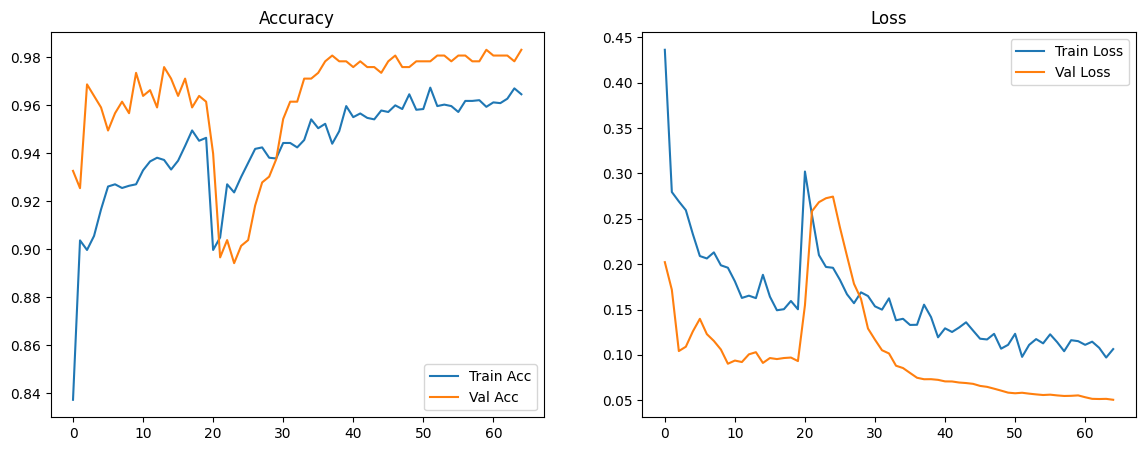

In [11]:
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history_phase1, history_phase2)

Evaluating on Test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9650 - loss: 0.1349 - top2: 0.9886
Test accuracy: 0.9802 | Top-2: 0.9926
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

Classification Report:
              precision    recall  f1-score   support

Early_Blight       1.00      0.96      0.98       162
     Healthy       0.93      1.00      0.96       102
 Late_Blight       1.00      0.99      0.99       141

    accuracy                           0.98       405
   macro avg       0.98      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



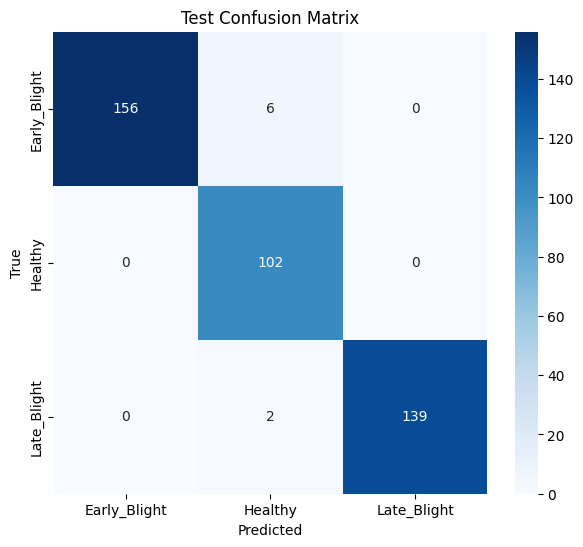

In [12]:
print("Evaluating on Test set...")
test_loss, test_acc, test_top2 = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f} | Top-2: {test_top2:.4f}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

In [13]:
model.save("potato_disease_classifier.h5")
print("model saved")

model saved
